## ___LightGBM, CatBoost - Supervised Boosting Learning___
---

## ___What is LightGBM?___

_LightGBM (Light Gradient Boosted Machine) is a distributed and efficient gradient boosting framework that uses tree-based learning. It’s histogram-based and places continuous values into discrete bins, which leads to faster training and more efficient memory usage._

### ___Advantages___
* _Faster training speed and higher efficiency_
* _Lower memory usage_
* _Better accuracy_
* _Support of parallel and GPU learning_
* _Capable of handling large-scale data_

_The framework uses a leaf-wise tree growth algorithm, which is unlike many other tree-based algorithms that use depth-wise growth. Leaf-wise tree growth algorithms tend to converge faster than depth-wise ones. However, they tend to be more prone to overfitting._

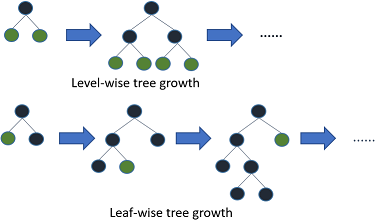

```
LGBMClassifier(boosting_type='gbdt', num_leaves=31, max_depth=- 1, learning_rate=0.1, n_estimators=100, subsample_for_bin=200000, objective=None, class_weight=None, min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, random_state=None, n_jobs=- 1, silent=True, importance_type='split', **kwargs)
```

_LightGBM can also handle categorical features by taking the input of feature names. It does not convert to one-hot coding, and is much faster than one-hot coding. LGBM uses a special algorithm to find the split value of categorical features._

_By default, LightGBM is able to handle missing values._

_It uses a novel technique of __Gradient-based One-Side Sampling (GOSS)__ to filter out the data instances for finding a split value. LightGBM is prefixed as ‘Light’ because of its high speed. LightGBM is popular as it can handle the large size of data and takes lower memory to run._

_GOSS keeps all the instances with large gradients and performs random sampling on the instances with small gradients. For example, let’s say I have 500K rows of data where 10k rows have higher gradients. So my algorithm will choose (10k rows of higher gradient+ x% of remaining 490k rows chosen randomly). Assuming x is 10%, total rows selected are 59k out of 500K on the basis of which split value if found._

_The basic assumption taken here is that samples with training instances with small gradients have smaller training error and it is already well-trained._

_In order to keep the same data distribution, when computing the information gain, GOSS introduces a constant multiplier for the data instances with small gradients. Thus, GOSS achieves a good balance between reducing the number of data instances and keeping the accuracy for learned decision trees._

_[Reference](https://neptune.ai/blog/lightgbm-parameters-guide)_
_[Reference](https://www.kaggle.com/prashant111/lightgbm-classifier-in-python)_

In [1]:
from sklearn.datasets import load_boston
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

def dataset_to_df(load):
    # Load the input data into the dataframe
    df = pd.DataFrame(load.data, columns=load.feature_names)
    
    # Add the output data into the dataframe
    df['label'] = pd.Series(load.target)
    
    # Return the dataframe
    return df

df = dataset_to_df(load_boston())

In [2]:
# Getting the output variable
y = df['label']

# Getting the input variables
X = df.drop(['label'], axis=1)

# Diving our input and output into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
                                    X, y, 
                                    test_size=0.33, 
                                    random_state=42
                                   )

In [3]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=10, scoring_fit='neg_mean_squared_error',
                       scoring_test=r2_score, do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    best_model = fitted_model.best_estimator_
    
    if do_probabilities:
          pred = fitted_model.predict_proba(X_test_data)
    else:
          pred = fitted_model.predict(X_test_data)
    
    score = scoring_test(y_test_data, pred)
    
    return [best_model, pred, score]

In [4]:
from lightgbm import LGBMRegressor

# Defining our estimator, the algorithm to optimize
models_to_train = [LGBMRegressor()]

# Defining the hyperparameters to optimize
grid_parameters = [
    { # LightGBM
        'n_estimators': [400, 700],
        'learning_rate': [0.12],
        'colsample_bytree': [0.7],
        'max_depth': [4],
        'num_leaves': [10],
        'reg_alpha': [1.1, 1.2],
        'reg_lambda': [1.1, 1.2],
        'min_split_gain': [0.3],
        'subsample': [0.8],
        'subsample_freq': [10]
    }
]

In [5]:
models_preds_scores = []

for i, model in enumerate(models_to_train):
    params = grid_parameters[i]
    
    result = algorithm_pipeline(X_train, X_test, y_train, y_test, 
                                 model, params, cv=2)
    models_preds_scores.append(result)

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   39.6s finished


In [6]:
for result in models_preds_scores:
    print('Model: {0}, Score: {1}'.format(type(result[0]).__name__, result[2]))

Model: LGBMRegressor, Score: 0.8625926353960542


## ___What is CatBoost?___

_“CatBoost” name comes from two words “Category” and “Boosting”._

_Catboost introduces two critical algorithmic advances - the implementation of ordered boosting, a permutation-driven alternative to the classic algorithm, and an innovative algorithm for processing categorical features._

_Both techniques are using random permutations of the training examples to fight the prediction shift caused by a special kind of target leakage present in all existing implementations of gradient boosting algorithms._

_[Reference](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html)_

_[Reference](https://towardsdatascience.com/https-medium-com-talperetz24-mastering-the-new-generation-of-gradient-boosting-db04062a7ea2)_

In [21]:
import catboost as ctb
from sklearn.datasets import load_breast_cancer
from sklearn import metrics

# load the iris datasets
dataset = load_breast_cancer()
X = dataset.data; y = dataset.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# fit a CART model to the data
model = ctb.CatBoostClassifier(verbose =0)
model.fit(X_train, y_train)
print(model)

In [22]:
# make predictions
expected_y  = y_test
predicted_y = model.predict(X_test)

In [23]:
# summarize the fit of the model
print(metrics.classification_report(expected_y, predicted_y))
print(metrics.confusion_matrix(expected_y, predicted_y))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97        50
           1       0.99      0.98      0.98        93

    accuracy                           0.98       143
   macro avg       0.97      0.98      0.98       143
weighted avg       0.98      0.98      0.98       143

[[49  1]
 [ 2 91]]


## ___Hyperparamters___

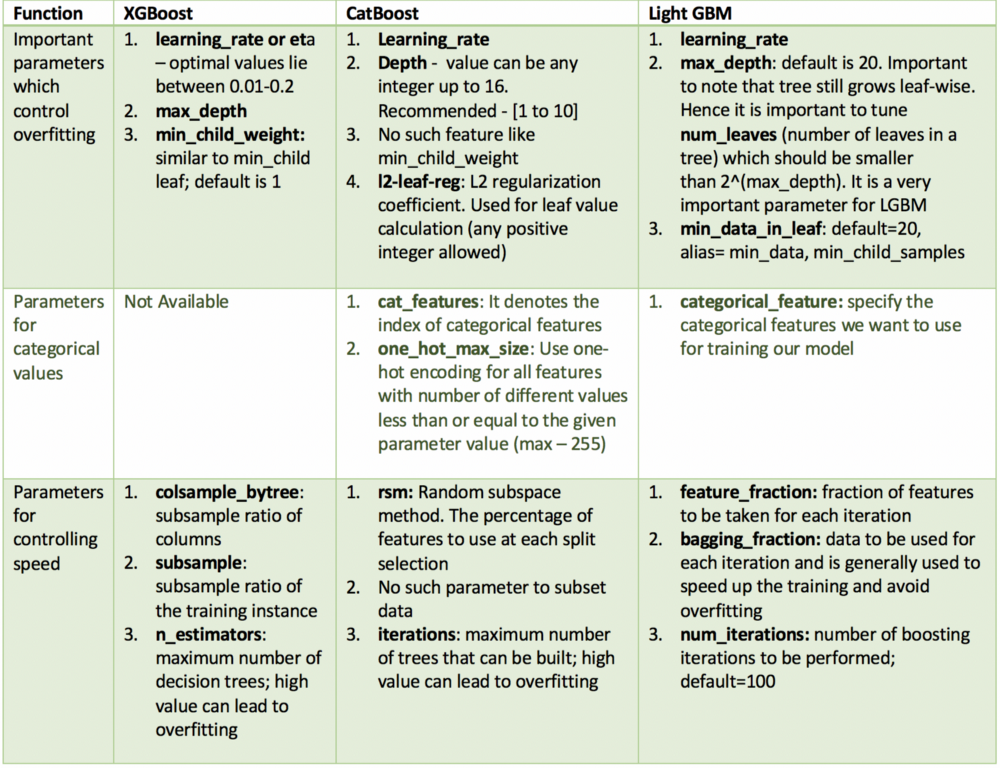